<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/regressao_linear_incidencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import io
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
idhm = pd.read_excel('https://github.com/mirianbatista/covid-fatores/blob/master/atlas2013_dadosbrutos_pt.xlsx?raw=true', sheet_name=1, dtype = {'UF': str, 'Codmun7':str}) 

In [ ]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
cols = 'state','city','city_ibge_code','date','estimated_population_2019','last_available_confirmed_per_100k_inhabitants'
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, usecols=cols, parse_dates=["date"], dtype={"city_ibge_code": str})
covid = covid[covid.date == max(covid.date)]
covid

,city,city_ibge_code,date,estimated_population_2019,last_available_confirmed_per_100k_inhabitants,state
9917,Acrelândia,1200013,2021-06-30,15256.0,10858.61846,AC
9918,Assis Brasil,1200054,2021-06-30,7417.0,23400.58402,AC
9919,Brasiléia,1200104,2021-06-30,26278.0,10815.66924,AC
9920,Bujari,1200138,2021-06-30,10266.0,10902.11132,AC
9921,Capixaba,1200179,2021-06-30,11733.0,5454.69687,AC
...,...,...,...,...,...,...
2337323,Tupirama,1721257,2021-06-30,1891.0,9261.18626,TO
2337324,Tupiratins,1721307,2021-06-30,2671.0,5899.59692,TO
2337325,Wanderlândia,1722081,2021-06-30,11683.0,7576.27408,TO
2337326,Xambioá,1722107,2021-06-30,11540.0,19513.88889,TO


In [ ]:
idhmcovid = pd.merge(idhm, covid, left_on="Codmun7", right_on="city_ibge_code", how="left") 
idhmcovid = idhmcovid.loc[(idhmcovid['estimated_population_2019'] > 20000) & (idhmcovid['ANO'] == 2010)].dropna()
idhmcovid.head()

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,...,PESO15,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,date,estimated_population_2019,last_available_confirmed_per_100k_inhabitants,state
11130,2010,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,47.37,94.50,83.18,5.84,8.67,1.22,1.52,11.99,1.68,13.00,2.72,15.76,57.62,63.21,66.39,20.36,18.97,25.81,22.03,17.82,7.79,90.45,107.69,45.99,35.40,21.23,85.25,92.88,34.60,34.15,10.50,...,17976,1577,4788,1536,16399,1497,3211,1433,13188,399,429,413,2196,5170,1425,1145,747,8605,6284,10422,24392,13970,20434.0,2401.0,1602.0,16431.0,24097,22429,0.368,0.629,0.641,0.526,0.763,0.657,Alta Floresta D'Oeste,1100015,2021-06-30,22945.0,17089.05315,RO
11131,2010,11,110002,1100023,ARIQUEMES,73.36,1.91,19.2,20.53,46.68,96.12,87.69,4.36,9.18,1.55,1.09,7.90,1.13,8.53,1.89,10.48,58.43,60.96,72.93,22.22,22.30,23.11,19.35,16.74,3.96,94.78,106.62,58.77,46.92,27.95,85.46,91.31,37.07,40.96,12.91,...,65521,5497,18019,5420,60024,5330,12522,5360,47502,1522,1565,1564,8593,19709,3943,4515,2739,32552,23467,13828,90353,76525,74725.0,9256.0,5256.0,60213.0,89766,88730,0.514,0.648,0.702,0.600,0.806,0.716,Ariquemes,1100023,2021-06-30,107863.0,19632.40598,RO
11133,2010,11,110004,1100049,CACOAL,74.27,1.90,14.3,15.38,43.79,96.41,88.56,5.57,9.74,1.01,0.80,8.29,0.93,8.94,1.57,10.95,66.69,71.14,71.07,17.74,16.28,21.60,15.57,12.58,7.33,100.81,108.09,80.94,54.45,38.23,88.24,93.02,43.97,51.33,17.45,...,58893,4729,15592,4770,54164,4617,10863,4634,43301,1180,1218,1216,6454,15675,4378,3708,2333,29758,21922,16653,78574,61921,66376.0,7473.0,4547.0,54356.0,78141,76876,0.488,0.698,0.718,0.620,0.821,0.727,Cacoal,1100049,2021-06-30,85359.0,15661.34609,RO
11138,2010,11,110009,1100098,ESPIGÃO D'OESTE,74.15,2.22,15.4,16.47,46.83,96.41,88.54,5.21,9.55,2.17,1.28,11.33,1.11,12.18,2.54,14.87,65.19,70.26,66.35,18.72,17.42,28.68,16.09,12.32,4.97,97.47,106.42,71.24,32.47,18.67,86.99,92.12,38.96,30.29,9.83,...,20934,1639,5407,1617,19295,1647,3768,1645,15527,501,519,459,2492,5866,1496,1399,830,10260,7564,8119,28729,20610,23897.0,2849.0,1653.0,19395.0,28510,27791,0.402,0.619,0.672,0.536,0.819,0.691,Espigão D'Oeste,1100098,2021-06-30,32374.0,9894.47928,RO
11139,2010,11,110010,1100106,GUAJARÁ-MIRIM,74.39,2.61,14.8,15.92,56.67,96.53,88.88,4.82,8.17,2.20,1.77,8.06,1.99,8.70,2.78,10.47,48.13,51.27,66.81,25.26,26.82,24.91,26.61,21.91,8.27,96.87,107.88,61.70,43.87,17.32,85.03,91.06,31.72,40.96,5.66,...,27975,2595,7875,2513,25380,2382,5280,2264,20100,814,847,834,4403,9694,2006,2161,1334,13993,10094,6449,41656,35207,33017.0,4602.0,2575.0,25841.0,39928,38203,0.486,0.537,0.657,0.519,0.823,0.663,Guajará-Mirim,1100106,2021-06-30,46174.0,11543.08789,RO


In [ ]:
idhmcovid_cor_abs = idhmcovid.corr(method='spearman').abs()
correlacao_abs = idhmcovid_cor_abs.loc['last_available_confirmed_per_100k_inhabitants'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[1:101]
correlacao_abs

,indicador,last_available_confirmed_per_100k_inhabitants
1,T_OCUPDESLOC_1,0.545840
2,RDPCT,0.535245
3,IDHM_R,0.532256
4,RDPC,0.532256
5,T_FLSUPER,0.530899
...,...,...
96,REN0,0.355043
97,E_ANOSESTUDO,0.352959
98,T_FBBAS,0.352746
99,TRABSC,0.350371


In [ ]:
idhmcovid_cor_abs_colin = idhmcovid_cor_abs[correlacao_abs['indicador']].unstack().sort_values(ascending=False).reset_index(name='correlation')
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.correlation >= 0.8]
idhmcovid_cor_abs_colin = pd.merge(idhmcovid_cor_abs_colin, correlacao_abs, left_on="level_0", right_on="indicador", how="right").rename(columns = {'last_available_confirmed_per_100k_inhabitants': 'cor_1'}).drop(columns='indicador')
idhmcovid_cor_abs_colin = pd.merge(idhmcovid_cor_abs_colin, correlacao_abs, left_on="level_1", right_on="indicador", how="right").rename(columns = {'last_available_confirmed_per_100k_inhabitants': 'cor_2'}).drop(columns='indicador')
idhmcovid_cor_abs_colin
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.cor_1 > idhmcovid_cor_abs_colin.cor_2]
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.level_0 != idhmcovid_cor_abs_colin.level_1]


In [ ]:
import numpy as np
idhmcovid_cor_abs_colin_cols = idhmcovid_cor_abs_colin.level_1.unique()
idhmcovid_cor_abs_colin_cols = np.append(idhmcovid_cor_abs_colin_cols, 'Codmun6')
idhmcovid_cor_abs_colin_cols

array(['IDHM_R', 'RDPC', 'T_FLSUPER', 'CORTE4', 'T_FBSUPER', 'RDPC4',
       'RDPC5', 'CORTE9', 'PPOB', 'PPOBCRI', 'CORTE3', 'REN5', 'RDPC3',
       'REN3', 'RDPC10', 'CORTE2', 'REN2', 'RDPC2', 'RENOCUP',
       'T_SUPER25M', 'PMPOB', 'T_NESTUDA_NTRAB_MMEIO', 'PMPOBCRI',
       'CORTE1', 'IDHM', 'T_ANALF11A14', 'RDPC1', 'T_FUNDIN_TODOS_MMEIO',
       'T_ATIV2529', 'P_SUPER', 'PIND', 'T_ATIV', 'T_ANALF18A24',
       'T_RMAXIDOSO', 'PINDCRI', 'T_ANALF15A17', 'MORT1', 'RPOB', 'MORT5',
       'RAZDEP', 'T_ATIV1824', 'T_ANALF25A29', 'T_ATIV18M', 'T_BANAGUA',
       'T_FUNDIN18MINF', 'T_FUND18A24', 'T_FREQFUND1824', 'T_MED18A20',
       'T_MED18A24', 'IDHM_E', 'IDHM_L', 'ESPVIDA', 'T_MED19A21',
       'AGUA_ESGOTO', 'REN1', 'T_ANALF25M', 'T_ANALF18M', 'T_ANALF15M',
       'T_FREQFUND1517', 'T_MED18M', 'P_FORMAL', 'P_FUND',
       'I_ESCOLARIDADE', 'T_FUND18M', 'I_FREQ_PROP', 'T_FUND16A18',
       'T_FUND15A17', 'T_FUND25M', 'T_CRIFUNDIN_TODOS',
       'T_ATRASO_2_BASICO', 'T_MED25M', 'T_ATRA

In [ ]:
pd.DataFrame(idhmcovid_cor_abs_colin.level_1.unique(), columns=['col1']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   col1    90 non-null     object
dtypes: object(1)
memory usage: 848.0+ bytes


In [ ]:
corr_pos_neg = idhmcovid[correlacao_abs['indicador']].drop(columns=idhmcovid_cor_abs_colin_cols)
corr_posit_negat = corr_pos_neg.columns
corr_pos_neg

,T_OCUPDESLOC_1,RDPCT,EMP,T_DENS,T_FREQSUPER1517,T_FREQMED1824,T_MULCHEFEFIF014,T_LIXO,PRENTRAB
11130,1.15,512.46,2.83,22.58,2.73,4.73,14.51,94.05,79.37
11131,0.16,698.01,2.30,27.15,0.18,4.99,18.07,96.72,87.28
11133,0.43,750.20,2.09,20.50,0.44,6.91,12.80,98.17,82.06
11138,0.53,606.09,1.09,19.97,0.49,9.35,24.70,91.07,83.67
11139,0.27,517.03,0.46,43.40,0.35,10.55,22.46,90.41,78.47
...,...,...,...,...,...,...,...,...,...
16673,1.17,710.78,2.15,11.45,0.00,5.28,8.87,98.83,79.32
16680,2.23,559.90,0.94,22.12,1.20,5.08,16.69,98.84,83.49
16685,0.62,798.44,0.91,15.39,2.69,7.61,11.39,99.34,84.67
16688,2.36,764.73,0.86,28.09,1.12,7.80,19.26,97.60,84.34


In [ ]:
incidencia = idhmcovid.last_available_confirmed_per_100k_inhabitants
xtrain_corr_pos_neg, xtest_corr_pos_neg, ytrain_corr_pos_neg, ytest_corr_pos_neg = train_test_split(corr_pos_neg, incidencia, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_pos_neg = LinearRegression()
linreg_corr_pos_neg.fit(corr_pos_neg, incidencia)
print('linear model coeff (w): {}'
.format(linreg_corr_pos_neg.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_pos_neg.intercept_))
print('R-squared score (all data): {:.3f}'
.format(linreg_corr_pos_neg.score(corr_pos_neg, incidencia)))
print('R-squared score (train): {:.3f}'
.format(linreg_corr_pos_neg.score(xtrain_corr_pos_neg, ytrain_corr_pos_neg)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_pos_neg.score(xtest_corr_pos_neg, ytest_corr_pos_neg)))

linear model coeff (w): [-4.45159438e+02  6.58971697e-01  5.35082490e+02 -2.33761083e+01
  6.73140884e+02 -1.03613931e+01  7.29808452e+00  2.96635360e+00
  8.52243186e+01]
linear model intercept (b): 1670.274
R-squared score (all data): 0.343
R-squared score (train): 0.344
R-squared score (test): 0.340


In [ ]:
pd.DataFrame({'variavel': corr_posit_negat, 'coeficiente': linreg_corr_pos_neg.coef_}).sort_values('coeficiente', ascending=False)

,variavel,coeficiente
4,T_FREQSUPER1517,673.140884
2,EMP,535.082490
8,PRENTRAB,85.224319
6,T_MULCHEFEFIF014,7.298085
7,T_LIXO,2.966354
1,RDPCT,0.658972
5,T_FREQMED1824,-10.361393
3,T_DENS,-23.376108
0,T_OCUPDESLOC_1,-445.159438


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

X = corr_pos_neg
y = incidencia
model = LinearRegression()

preprocessor = make_column_transformer(
    (StandardScaler(), corr_posit_negat),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    LinearRegression()
)

_ = model.fit(X, y)

X_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X),
    columns=corr_posit_negat
)

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

coefs = pd.DataFrame(
    [est.named_steps['linearregression'].coef_ * X_preprocessed.std(axis=0) for est in cv_model['estimator']], columns=corr_posit_negat
)


coefs1 = pd.DataFrame(
    [model['linearregression'].coef_ * X_preprocessed.std(axis=0)], columns=corr_posit_negat
)
coefs1

,T_OCUPDESLOC_1,RDPCT,EMP,T_DENS,T_FREQSUPER1517,T_FREQMED1824,T_MULCHEFEFIF014,T_LIXO,PRENTRAB
0,-714.654863,185.733607,608.119541,-314.649632,703.428497,-35.609434,67.735774,29.826342,794.550117


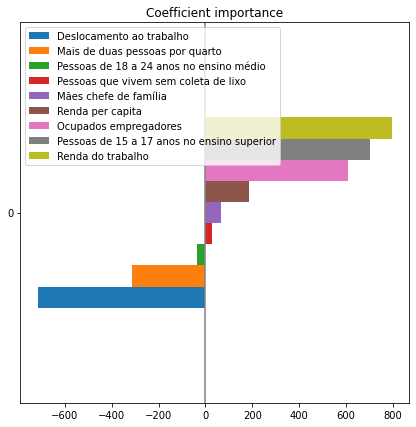

In [ ]:
a = pd.melt(coefs1, var_name="var", value_name="Value").sort_values(by="Value")
b = a['var'].to_list()
c = coefs1[b]
d = c.rename(columns = {"T_OCUPDESLOC_1": "Deslocamento ao trabalho", "RDPCT": "Renda per capita", "EMP": "Ocupados empregadores", "T_DENS": "Mais de duas pessoas por quarto", "T_FREQSUPER1517": "Pessoas de 15 a 17 anos no ensino superior", "T_FREQMED1824": "Pessoas de 18 a 24 anos no ensino médio", "T_MULCHEFEFIF014": "Mães chefe de família","T_LIXO": "Pessoas que vivem sem coleta de lixo", "PRENTRAB": "Renda do trabalho"})
d.plot(kind='barh', figsize=(9, 7))
plt.title('Coefficient importance')
plt.legend(loc="upper left")
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

**T_OCUPDESLOC_1**:    Percentual de pessoas em domicílios vulneráveis à pobreza e que gastam mais de uma hora até o trabalho\
**RDPCT**: Renda domiciliar per capita média, exceto renda nula\
**EMP**: Percentual de ocupados de 18 anos ou mais que são empregadores\
**T_DENS**: Percentual da população que vive em domicílios com densidade superior a 2 pessoas por dormitório\
**T_FREQSUPER1517**: Percentual da população de 15 a 17 anos de idade frequentando o ensino superior\
**T_FREQMED1824**: Percentual da população de 18 a 24 anos de idade frequentando o ensino médio\
**T_MULCHEFEFIF014**: Percentual de mães chefes de família, sem fundamental completo e com pelo menos um filho menor de 15 anos de idade\
**T_LIXO**: Percentual da população que vive em domicílios urbanos com serviço de coleta de lixo\
**PRENTRAB**: Percentual da renda proveniente de rendimentos do trabalho\
\
descrição de todas as variáveis do IDHM: https://docs.google.com/spreadsheets/d/1CBN0-0Og-hRN-ovSAEbobgzhUxTZt3CoVsq1YMXpss4/edit?usp=sharing

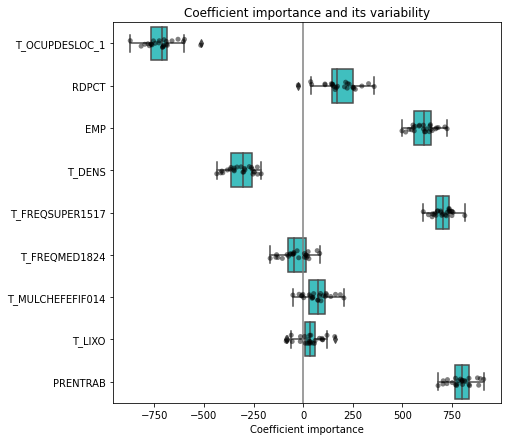

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

In [ ]:
pred_corr_pos_neg = model.predict(X)
print('Mean squared error: %.2f'
      % mean_squared_error(y, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(y, pred_corr_pos_neg))

Mean squared error: 11251052.66
Coefficient of determination: 0.34


In [ ]:
pred_corr_pos_neg = linreg_corr_pos_neg.predict(xtest_corr_pos_neg)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_pos_neg, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_pos_neg, pred_corr_pos_neg))

Mean squared error: 11209042.59
Coefficient of determination: 0.34


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_pos_neg, y=pred_corr_pos_neg, mode='markers', text=idhmcovid['Município'] + "-" + idhmcovid['state'])) 
fig.update_layout(title="Valores reais e previstos das maiores correlações de incidência de COVID-19 com indicadores do IDHM")
fig.show()

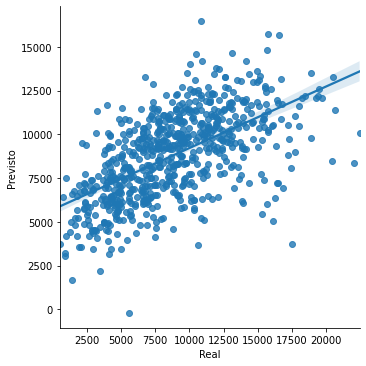

In [ ]:
df_corr_pos_neg = pd.DataFrame ({'Real': ytest_corr_pos_neg, 'Previsto': pred_corr_pos_neg}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_pos_neg)

In [ ]:
idhmcovid.sort_values('PRENTRAB')

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,...,PESO15,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,date,estimated_population_2019,last_available_confirmed_per_100k_inhabitants,state
12813,2010,27,270320,2703205,IGREJA NOVA,71.23,2.21,25.7,28.01,56.22,93.99,83.79,7.12,7.72,12.26,7.68,36.97,12.84,40.07,24.29,48.01,38.37,44.21,52.89,21.85,23.32,32.81,39.78,32.47,14.30,135.83,154.39,84.63,73.29,7.67,92.29,96.18,24.02,63.75,3.45,...,16569,1588,4969,1514,14981,1472,3381,1440,11600,433,411,410,2273,5366,1659,1252,779,8238,5779,18517,23292,4775,19059.0,2483.0,1586.0,14990.0,23208,22418,0.266,0.543,0.568,0.428,0.771,0.556,Igreja Nova,2703205,2021-06-30,24499.0,5023.18393,AL
11317,2010,15,150250,1502509,CHAVES,71.15,2.53,23.5,25.33,78.63,94.54,83.81,4.30,4.95,18.84,12.34,27.07,14.83,28.92,19.53,33.74,25.84,27.62,77.79,18.64,21.92,18.19,55.52,50.46,4.02,94.26,113.07,29.78,37.77,1.27,72.65,75.60,5.27,27.00,0.23,...,12662,1418,4283,1366,11244,1322,2865,1245,8379,600,590,523,2829,5950,903,1334,643,5758,3803,18495,21005,2510,15366.0,2752.0,1480.0,11134.0,20968,16706,0.120,0.327,0.453,0.234,0.769,0.516,Chaves,1502509,2021-06-30,23717.0,2438.61700,PA
13222,2010,29,292210,2922102,MUNDO NOVO,72.43,2.46,20.6,22.18,59.02,95.20,85.82,8.45,8.15,4.66,3.54,22.88,6.42,24.89,10.36,29.72,44.60,51.45,49.49,19.43,19.49,34.63,35.97,29.05,15.88,102.10,123.91,43.49,34.27,10.84,86.21,89.86,27.10,30.99,4.89,...,17402,1638,4910,1565,15764,1437,3272,1386,12492,386,459,460,2380,5726,2061,1315,747,8606,6356,10831,24395,13564,20154.0,2737.0,1712.0,15705.0,24342,24034,0.266,0.544,0.590,0.429,0.791,0.606,Mundo Novo,2922102,2021-06-30,26776.0,3040.41528,BA
12656,2010,26,260560,2605608,FLORES,69.67,2.53,27.9,30.06,59.20,93.55,81.30,10.88,8.82,5.66,5.61,32.94,8.37,35.34,15.70,41.25,52.96,55.71,73.49,21.72,22.99,26.51,25.32,21.30,0.00,102.19,120.09,54.45,49.54,9.03,86.83,93.48,33.51,41.24,3.38,...,16338,1318,4018,1248,15020,1167,2700,1127,12320,377,415,388,2070,4574,2413,1024,628,8361,6357,12805,22169,9364,18394.0,2060.0,1375.0,14958.0,22123,21612,0.236,0.567,0.556,0.423,0.745,0.544,Flores,2605608,2021-06-30,22624.0,4394.72986,PE
12154,2010,23,231030,2310308,PARAMBU,70.85,2.52,24.0,25.80,62.14,94.44,83.33,9.86,10.11,7.45,6.38,35.09,10.47,38.04,20.99,44.17,72.10,77.56,69.07,16.76,14.96,23.71,11.14,7.48,7.22,98.56,110.29,63.88,55.18,6.42,85.89,92.81,37.17,43.06,2.98,...,22340,2085,5770,1893,20255,1718,3685,1653,16570,522,566,562,3071,7398,3086,1778,1030,11650,8669,17203,31309,14106,26081.0,3619.0,2023.0,20438.0,31257,30486,0.238,0.639,0.570,0.460,0.764,0.526,Parambu,2310308,2021-06-30,31521.0,4473.05675,CE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11434,2010,16,160050,1600501,OIAPOQUE,71.71,3.74,20.0,21.31,63.17,95.38,84.86,2.04,8.55,3.24,2.50,9.05,2.46,9.82,4.81,12.25,47.74,52.18,61.57,21.35,22.64,28.22,30.91,25.18,10.21,112.51,122.26,81.58,46.44,16.10,89.93,94.47,32.02,31.37,3.06,...,12988,1360,4245,1301,11628,1292,2885,1258,8743,539,512,453,2486,5350,419,1136,673,6200,4170,6657,20509,13852,15431.0,2430.0,1342.0,11660.0,19982,17939,0.464,0.562,0.658,0.527,0.779,0.693,Oiapoque,1600501,2021-0

In [ ]:
fig = go.Figure(data=go.Scatter(x=y, y=idhmcovid['PRENTRAB'], mode='markers', text=idhmcovid['Município'] + "-" + idhmcovid['state'])) 
fig.update_layout(title="Percentual da renda proveniente de rendimentos do trabalho e a mortalidade de covid-19 por município")
fig.show()

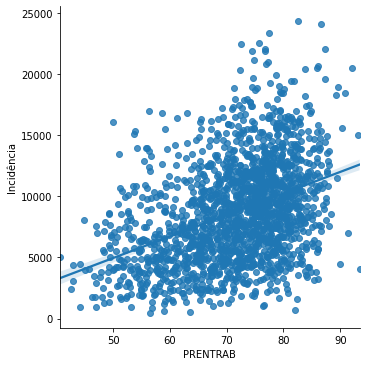

In [ ]:
inc_PRENTRAB = pd.DataFrame ({'PRENTRAB': idhmcovid['PRENTRAB'], 'Incidência': incidencia}) 
sns.lmplot(x="PRENTRAB", y="Incidência", data=inc_PRENTRAB)